<a href="https://colab.research.google.com/github/henrya2/MitsubaPlayground/blob/main/Scripting_a_renderer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mitsuba

!rm scenes.zip
!wget https://rgl.s3.eu-central-1.amazonaws.com/scenes/tutorials/scenes.zip

# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("./scenes.zip", 'r') as zObject:

    # Extracting all the members of the zip
    # into a specific location.
    zObject.extractall(
        path="../scenes/")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 109.6 MB/s eta 0:00:00
rm: cannot remove 'scenes.zip': No such file or directory
--2023-10-21 09:08:35--  https://rgl.s3.eu-central-1.amazonaws.com/scenes/tutorials/scenes.zip
Resolving rgl.s3.eu-central-1.amazonaws.com (rgl.s3.eu-central-1.amazonaws.com)... 3.5.135.126, 52.219.72.196, 52.219.140.177, ...
Connecting to rgl.s3.eu-central-1.amazonaws.com (rgl.s3.eu-central-1.amazonaws.com)|3.5.135.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9765095 (9.3M) [application/zip]
Saving to: ‘scenes.zip’

scenes.zip          100%[===================>]   9.31M  10.2MB/s    in 0.9s    

2023-10-21 09:08:36 (10.2 MB/s) - ‘scenes.zip’ saved [9765095/9765095]



In [2]:
import mitsuba as mi
import drjit as dr

mi.set_variant('llvm_ad_rgb')

scene = mi.load_file('../scenes/cbox.xml')

In [3]:
# Camera origin in world space
cam_origin = mi.Point3f(0, 1, 3)

# Camera view direction in world space
cam_dir = dr.normalize(mi.Vector3f(0, -0.5, -1))

# Camera width and height in world space
cam_width  = 2.0
cam_height = 2.0

# Image pixel resolution
image_res = [256, 256]

In [4]:
# Construct a grid of 2D coordinates
x, y = dr.meshgrid(
    dr.linspace(mi.Float, -cam_width  / 2,   cam_width / 2, image_res[0]),
    dr.linspace(mi.Float, -cam_height / 2,  cam_height / 2, image_res[1])
)

# Ray origin in local coordinates
ray_origin_local = mi.Vector3f(x, y, 0)

# Ray origin in world coordinates
ray_origin = mi.Frame3f(cam_dir).to_world(ray_origin_local) + cam_origin

In [5]:
ray = mi.Ray3f(o=ray_origin, d=cam_dir)

In [6]:
si = scene.ray_intersect(ray)

In [7]:
ambient_range = 0.75
ambient_ray_count = 256

In [8]:
# Initialize the random number generator
rng = mi.PCG32(size=dr.prod(image_res))

In [9]:
# Loop iteration counter
i = mi.UInt32(0)

# Accumulated result
result = mi.Float(0)

# Initialize the loop state (listing all variables that are modified inside the loop)
loop = mi.Loop(name="", state=lambda: (rng, i, result))

while loop(si.is_valid() & (i < ambient_ray_count)):
    # 1. Draw some random numbers
    sample_1, sample_2 = rng.next_float32(), rng.next_float32()

    # 2. Compute directions on the hemisphere using the random numbers
    wo_local = mi.warp.square_to_uniform_hemisphere([sample_1, sample_2])

    # Alternatively, we could also sample a cosine-weighted hemisphere
    # wo_local = mi.warp.square_to_cosine_hemisphere([sample_1, sample_2])

    # 3. Transform the sampled directions to world space
    wo_world = si.sh_frame.to_world(wo_local)

    # 4. Spawn a new ray starting at the surface interactions
    ray_2 = si.spawn_ray(wo_world)

    # 5. Set a maximum intersection distance to only account for the close-by geometry
    ray_2.maxt = ambient_range

    # 6. Accumulate a value of 1 if not occluded (0 otherwise)
    result[~scene.ray_test(ray_2)] += 1.0

    # 7. Increase loop iteration counter
    i += 1

# Divide the result by the number of samples
result = result / ambient_ray_count

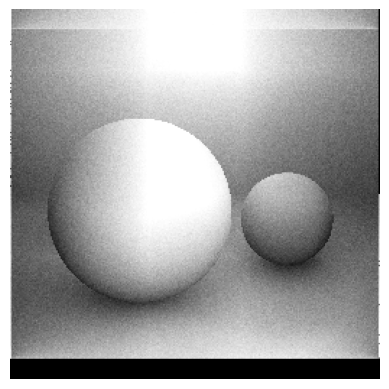

In [10]:
image = mi.TensorXf(result, shape=image_res)
import matplotlib.pyplot as plt

plt.imshow(image, cmap='gray'); plt.axis('off');